# Everything All At Once

In [3]:
!unzip parsed_patient_data.zip

Archive:  parsed_patient_data.zip
replace parsed_patient_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# Read in data
df = pd.read_csv("parsed_patient_data.csv")
y = df["0"]
X = df.drop("0", axis=1)

# Cool function for later
def plot_actual_vs_predicted(model, scaler=None):
    df_sorted = df.sort_values(by="0")

    y_sorted = df_sorted["0"]
    X_sorted = df_sorted.drop("0", axis=1)

    if scaler != None:
      X_sorted = scaler.transform(X_sorted)

    predictions = model.predict(X_sorted)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(y_sorted.array, label='Actual')
    ax.plot(predictions, label='Predicted')

    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Actual vs Predicted')
    ax.legend()

    ax.grid(True)

    plt.show()

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit scaler on train data
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

# Create scaled data evenly between 0 and 1
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Convert originals to tensors (I don't think this is necessary)
# X_train = tf.constant(X_train, dtype=tf.float32)
# X_test = tf.constant(X_test, dtype=tf.float32)
# y_train = tf.constant(y_train, dtype=tf.float32)
# y_test = tf.constant(y_test, dtype=tf.float32)

## Statistical Significance

In [8]:
import numpy as np
from scipy import stats

def analyze_model_significance(model, X_test, y_test, AVERAGE, alpha=0.05):
    # Make predictions using the trained model
    y_pred = model.predict(X_test)

    # Reshape y_test to a 1-dimensional array
    y_test = y_test.values.reshape(-1)

    # Calculate the mean squared error (MSE) for the model's predictions
    mse_model = np.mean((y_test - y_pred.reshape(-1)) ** 2)

    # Calculate the MSE for the baseline (average)
    mse_baseline = np.mean((y_test - AVERAGE) ** 2)

    # Calculate the differences between the squared errors of the model and the baseline
    squared_error_diff = (y_test - y_pred.reshape(-1)) ** 2 - (y_test - AVERAGE) ** 2

    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(squared_error_diff, np.zeros_like(squared_error_diff))

    # Compare the p-value with alpha and print the results
    if p_value < alpha:
        print("The model's performance is statistically significant compared to the baseline.")
        print(f"t-statistic: {t_statistic:.4f}")
        print(f"p-value: {p_value:.4f}")
    else:
        print("The model's performance is not statistically significant compared to the baseline.")
        print(f"t-statistic: {t_statistic:.4f}")
        print(f"p-value: {p_value:.4f}")

    # Print the MSE for the model and the baseline
    print(f"Model MSE: {mse_model:.4f}")
    print(f"Baseline MSE: {mse_baseline:.4f}")

    # Compare the model's MSE with the baseline MSE and suggest if the model is better
    if mse_model < mse_baseline:
        print("The model performs better than guessing the average.")
    else:
        print("The model does not perform better than guessing the average.")

# More Mass Models

## Model 1

In [ ]:
import tensorflow as tf
tf.random.set_seed(50)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(2449,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss="mse",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                 metrics=["mae"])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

history_10 = model_1.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test), callbacks=[reduce_lr])

In [ ]:
model_1.evaluate(X_scaled, y)

14/14 [==============================] - 0s 7ms/step - loss: 16483.2559 - mae: 110.4958


[16483.255859375, 110.4958267211914]

In [ ]:
plot_actual_vs_predicted(model_1, scaler)

## Model 2

In [ ]:
tf.random.set_seed(50)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(2449, 1)),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    # tf.keras.layers.Dense(1000),
    # tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])

history_2 = model_2.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test))

## Model 3 - Bishal's exact model

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
import tensorflow as tf

tf.random.set_seed(69)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scalewd = scaler.transform(X)

tf.random.set_seed(50)

model_3 = tf.keras.Sequential([
    BatchNormalization(input_shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_3.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_3 = model_3.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
model_3.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 46.6357 - mae: 46.6357


[46.6357421875, 46.6357421875]

14/14 [==============================] - 0s 3ms/step


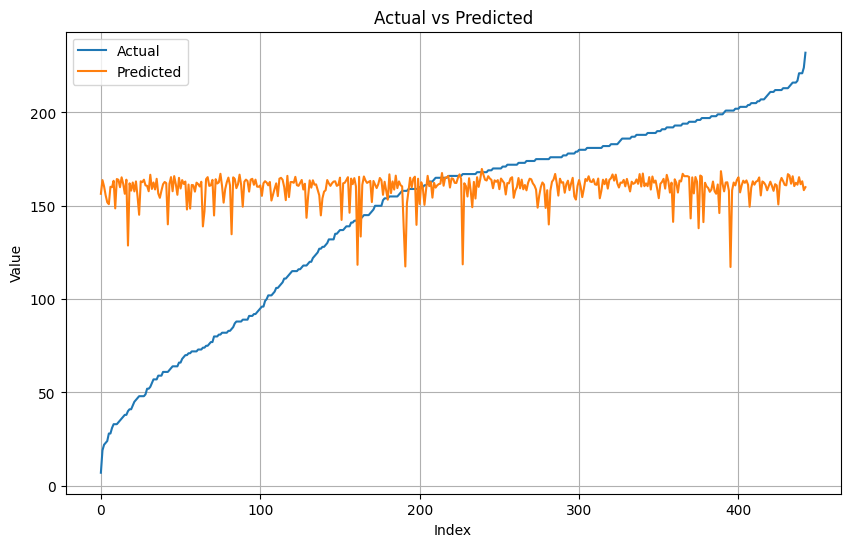

In [ ]:
plot_actual_vs_predicted(model_3)

In [ ]:
analyze_model_significance(model_3, X_test, y_test, AVERAGE=146)

3/3 [==============================] - 0s 4ms/step
The model's performance is not statistically significant compared to the baseline.
t-statistic: 1.8578
p-value: 0.0665
Model MSE: 3736.4393
Baseline MSE: 3372.5056
The model does not perform better than guessing the average.


## Model 4 - Basic Linear Regression

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def linear_regression(X_train, y_train, X_test, y_test):
    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate Mean Absolute Error for the test set
    mae = mean_absolute_error(y_test, y_test_pred)

    # Plot actual vs predicted values for training set
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='blue', label='Training Set')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Training Set: Actual vs Predicted')
    plt.legend()

    # Plot actual vs predicted values for testing set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, color='green', label='Testing Set')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Testing Set: Actual vs Predicted')
    plt.text(0.05, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

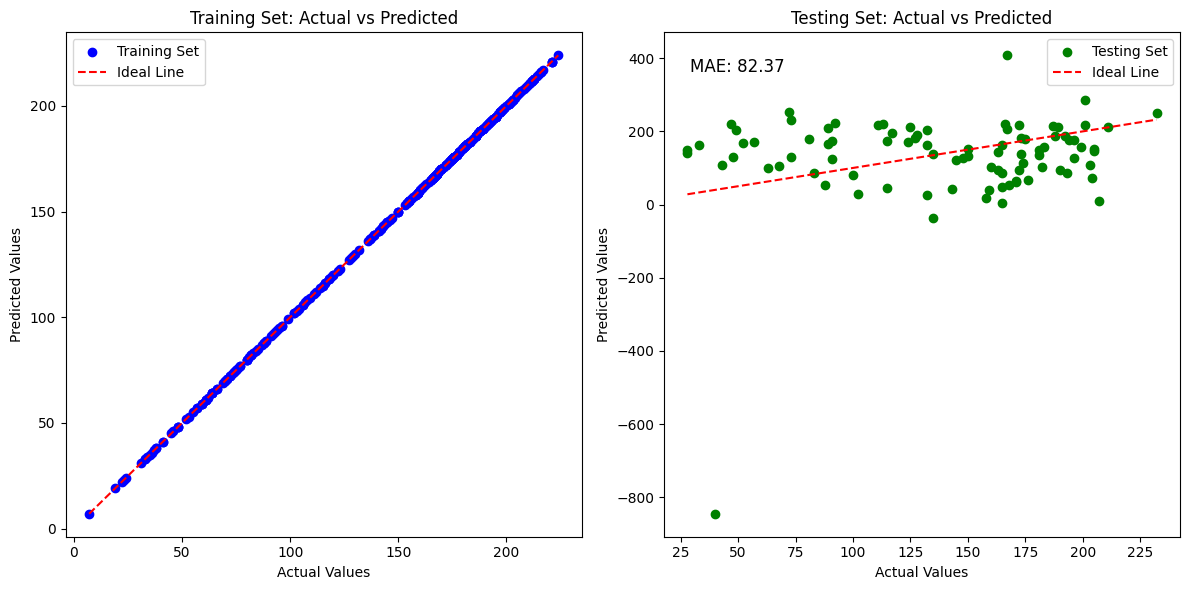

LinearRegression()

In [13]:
linear_regression(X_train, y_train, X_test, y_test)

## Model 5 - Polynomial Linear Regression

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(X_train, y_train, X_test, y_test, batch_size=1000):
    # Create polynomial features with degree 2
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    # Create a Stochastic Gradient Descent regressor
    model = SGDRegressor(max_iter=1000, tol=1e-3)

    # Train the model on the polynomial features using batching
    num_batches = int(np.ceil(len(X_train_poly) / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_train_poly))
        model.partial_fit(X_train_poly[start:end], y_train[start:end])

    # Make predictions on training and testing sets using batching
    y_train_pred = np.empty_like(y_train)
    y_test_pred = np.empty_like(y_test)

    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_train_poly))
        y_train_pred[start:end] = model.predict(X_train_poly[start:end])

    num_test_batches = int(np.ceil(len(X_test_poly) / batch_size))
    for i in range(num_test_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_test_poly))
        y_test_pred[start:end] = model.predict(X_test_poly[start:end])

    # Calculate Mean Absolute Error for the test set
    mae = mean_absolute_error(y_test, y_test_pred)

    # Plot actual vs predicted values for training set
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='blue', label='Training Set')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Training Set: Actual vs Predicted')
    plt.legend()

    # Plot actual vs predicted values for testing set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, color='green', label='Testing Set')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Testing Set: Actual vs Predicted')
    plt.text(0.05, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

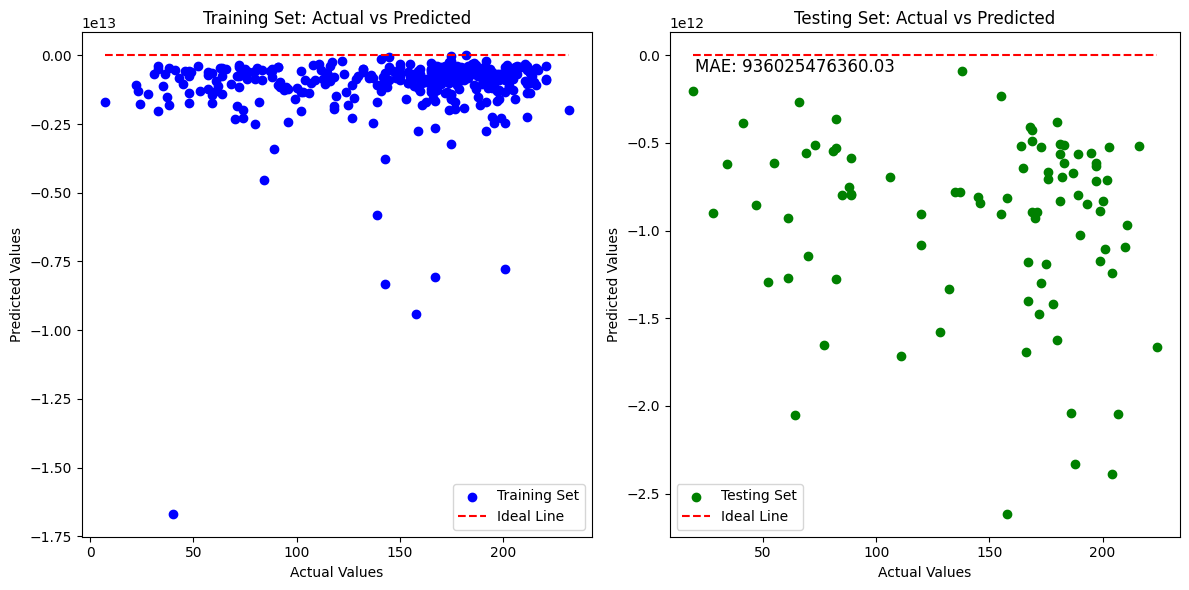

SGDRegressor()

In [6]:
polynomial_regression(X_train, y_train, X_test, y_test)

## Model 6 - Evaluating Bishals

In [30]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

model_6 = tf.keras.models.load_model("improve_accuracy3.h5")

standard_scaler = StandardScaler()
standard_scaler.fit(X) # This is technically not allowed

X_scaled_6 = standard_scaler.transform(X)
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_scaled_6, y, test_size=0.2)

14/14 [==============================] - 0s 5ms/step


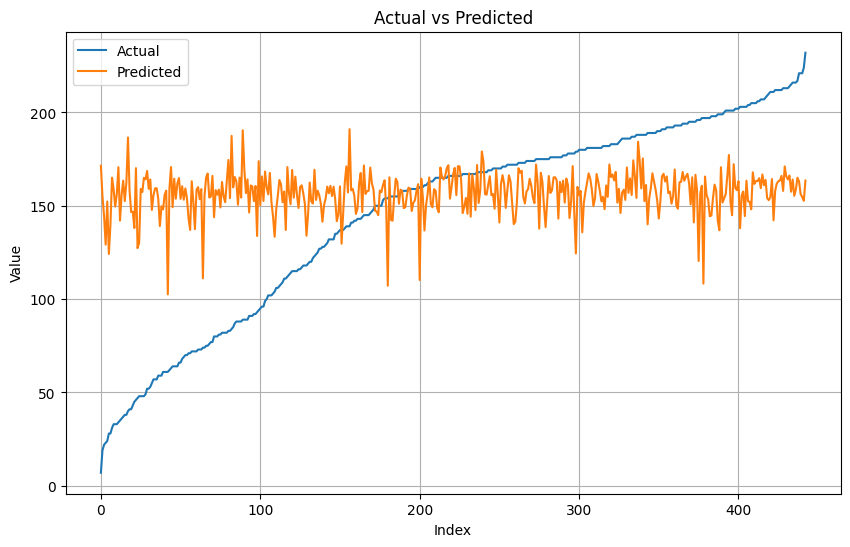

In [31]:
plot_actual_vs_predicted(model_6, standard_scaler)

In [32]:
analyze_model_significance(model_6, X_test_6, y_test_6, 146)

3/3 [==============================] - 0s 7ms/step
The model's performance is not statistically significant compared to the baseline.
t-statistic: 0.3308
p-value: 0.7416
Model MSE: 2507.5173
Baseline MSE: 2459.8764
The model does not perform better than guessing the average.


In [33]:
model_6.evaluate(X_test_6, y_test_6)

3/3 [==============================] - 0s 6ms/step - loss: 38.3170 - mae: 38.3170


[38.317047119140625, 38.317047119140625]